In [1]:
# load packages

import random
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm, transforms
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
from collections import Counter 
import pandas as pd
import datetime
import pickle
import xarray as xr
from scipy.stats import pearsonr

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.io import shapereader
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [2]:
# Load all parameters

# load trajectories

traj_path = '../analysis/input/particles_epibionts_obs_7d.zarr'
Traj = xr.open_zarr(traj_path)
plon = np.array(Traj['lon'])
plat = np.array(Traj['lat'])
pocean = np.array(Traj['openocean_flag'])
dist_traveled = np.array(Traj['distance_traveled'])
dist2release = np.array(Traj['distance_to_release'])
dist2coast = np.array(Traj['distance_to_coast'])
ptime = np.array(Traj['time'])

outputfreq = 0.5 #days

# load landmask, lon, lat, and startlon startlat

file = open('../particle_simulation/input/inputfiles_epibionts', 'rb')
inputfiles = pickle.load(file)
file.close()
landmask = inputfiles['landmask']
lon = inputfiles['lon']
lat = inputfiles['lat']
coastlon = inputfiles['lonSA'][:]
coastlat = inputfiles['latSA'][:]
file = open('../particle_simulation/input/inputfiles_epibionts_7d', 'rb')
inputfiles = pickle.load(file)
file.close()
startlon = inputfiles['releaselon'][:]
startlat = inputfiles['releaselat'][:]   
pID = inputfiles['releaseID'][:]


# make coastline mask (specified at T-point)
coastmask = np.zeros_like(landmask)
for i in range(coastmask.shape[1]):
    for j in range(coastmask.shape[0]):
        if landmask[j,i]==1:
            coastmask[j-1:j+2,i-1:i+2]=1
coastmask = coastmask + landmask

# load observation estimates

fieldobs = '../particle_simulation/input/Data_May_23th_2022.xls'
obs = pd.read_excel(fieldobs) 
lat_obs = np.array(obs.Latitude)
lon_obs = np.array(obs.Longitude)
est_obs = np.array(obs.Estimate)
err_obs = np.array(obs.Label)

## Observations: estimate 'from ocean' by looking at biotic interaction

Schoolchildren collected plastic at 44 beaches and identified whether there was any biological interaction or not. From this, and from a subset investigated at the lab, an estimate is made of what percentage of the litter items found on the beach could have arrived there with the currents. 

![image](https://miro.medium.com/max/1400/1*MHffFVBqW9U4PDO9JvVDwg.jpeg)

To compare the observations to a model simulation we assume that the longer an object is in the open ocean, the more likely it will show interaction. If using only ocean surface currents (no tidal currents, no Stokes drift and no windage), the virtual particles in the numerical simulation can not move onto land. We therefore make a distinction between the coastal zone (one ocean grid cell next to land) and the open ocean. In the coastal zone the particle might have originated from land and entered the ocean due to coastal processes that are not included or resolved in the hydographic fields used for the analysis.

I have also looked at the distance to the measurement location and the mean (Lagrangian) speed of the particles, but these diagnostics did not give better results.

In [ ]:
obs

> Q: Which values to take for the 'excluded' observations? Now I put them to 0.0

## Simulation: backward tracking

We track virtual particles backward in time for 100 days from each observation location. These particles are released daily in the year leading up to the measurement leading to 803.000 particles in total, or 18.250 particles per measurement location.

The virtual particles are transported by the ocean surface currents from the [MOi dataset](https://www.mercator-ocean.eu/en/solutions-expertise/accessing-digital-data/product-details/?offer=4217979b-2662-329a-907c-602fdc69c3a3&system=d35404e4-40d3-59d6-3608-581c9495d86a). No artifical diffusion is added to the particle movement, but to account for dispersion the particle release location is offset by a small (<1/25 degree) random number, so no two particles were released at exactly the same time and place. For this simulation, the role of wind, waves and tides on the movement of the plastic items is not taken into account, nor the buoyancy changes or fragmentation processes. With respect to the time scale of interest, we argue that these effects are of less importance, but we leave open the possibility to add an additional simulation where we do include the impact of wind on particle transport.

In [ ]:
# MAIN FIGURE - plot showing example trajectories towards each measurement location and correlation

fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios = [1])


# add figure map
ax1 = fig.add_subplot(gs[:,0])

landmask[landmask==0]=3
landmask[landmask==1]=18
ax1.pcolor(lon[600,:],lat[:,300],landmask,shading='nearest',
           cmap='tab20c',vmin=0, vmax=19, alpha=0.9)

particles2plot = np.random.randint(plon.shape[0], size=1000)

for p in particles2plot:
    ax1.plot(plon[p,:],plat[p,:],c='k',linewidth=0.1)

for measurement in range(len(obs)):
    if obs.Label[measurement] == 'confident':
        ax1.scatter(lon_obs[measurement],lat_obs[measurement],s=(est_obs[measurement]+1)*30,color='#38761d',alpha=0.5,zorder=2000)
    if obs.Label[measurement] == 'low':
        ax1.scatter(lon_obs[measurement],lat_obs[measurement],s=(est_obs[measurement]+1)*30,color='#b45f06',alpha=0.5,zorder=2000)
    if obs.Label[measurement] == 'excluded':
        ax1.scatter(lon_obs[measurement],lat_obs[measurement],s=20,color='#990000',alpha=0.5,zorder=2000)

        
ax1.scatter(0,0,s=30,color='#bcbcbc',alpha=0.5,label=' 1%')        
ax1.scatter(0,0,s=150,color='#bcbcbc',alpha=0.5,label=' 5% observed items from ocean estimate')  
ax1.scatter(0,0,s=300,color='#bcbcbc',alpha=0.5,label='10%')  

ax1.plot([0,1],[0,1],c='k',linewidth=1,label='100-day backwards example trajectories')

ax1.legend(prop={"size":11}, ncol=1, loc='upper right')
ax1.set_xlim([-120,-69])
ax1.set_ylim([-50,34])
ax1.set_xlabel('Longitude ($^{\circ}$E)')
ax1.set_ylabel('Latitude ($^{\circ}$N)')

## Add second panel with resulting correlation

ax2 = fig.add_subplot(gs[:,1])
ax3 = ax2.twiny()
omax=33 #xlimit for observations
mmax=101 #xlimit for model


for oloc in range(best_fit.shape[0]):
    ax3.scatter(best_fit[oloc,np.argmax(corr)],lat_obs[oloc],s=50,color='k',marker=5,alpha=0.5,zorder=200)
    
    odata = obs.Estimate[oloc]
    mdata = best_fit[oloc,np.argmax(corr)]
    
    
    if obs.Label[oloc] == 'confident':
        ax2.scatter(obs.Estimate[oloc],lat_obs[oloc],s=30,color='g',alpha=1,zorder=300)
        if mmax/omax*odata > mdata:
            ax3.plot([mdata,mmax/omax*odata],[lat_obs[oloc],lat_obs[oloc]],color='k',linewidth=0.3)
        else:
            ax3.plot([mmax/omax*odata,mdata],[lat_obs[oloc],lat_obs[oloc]],color='k',linewidth=0.3)
    if obs.Label[oloc] == 'low':
        ax2.scatter(obs.Estimate[oloc],lat_obs[oloc],s=30,color='orange',alpha=1,zorder=300)
        if mmax/omax*odata > mdata:
            ax3.plot([mdata,mmax/omax*odata],[lat_obs[oloc],lat_obs[oloc]],color='orange',linewidth=0.5)
        else:
            ax3.plot([mmax/omax*odata,mdata],[lat_obs[oloc],lat_obs[oloc]],color='orange',linewidth=0.5)
    if obs.Label[oloc] == 'excluded':
        ax2.scatter(obs.Estimate[oloc],lat_obs[oloc],s=30,color='red',alpha=1,zorder=300)
        if mmax/omax*odata > mdata:
            ax3.plot([mdata,mmax/omax*odata],[lat_obs[oloc],lat_obs[oloc]],color='red',linewidth=0.5)
        else:
            ax3.plot([mmax/omax*odata,mdata],[lat_obs[oloc],lat_obs[oloc]],color='red',linewidth=0.5)    

#get legends
ax2.scatter(10,10,s=30,color='g',label='high confidence observation')
ax2.scatter(10,10,s=30,color='orange',label='low confidence observation')
ax2.scatter(10,10,s=30,color='red',label='excluded observation')
ax2.scatter(10,10,s=50,color='k',marker=5,alpha=0.5,label='model estimate')

#axis settings
ax2.set_ylim([-50,34])
ax2.set_xlim([0,omax])
ax3.set_xlim([0,mmax])

ax2.set_yticklabels([])
ax2.set_xlabel('Observed items from ocean estimate (%)')     
ax3.set_xlabel('Modeled particles in open ocean longer than 70 days (%)')
ax2.legend(loc='lower right',prop={"size":12})

#add text box with correlation and p-value
c_conf, p_conf = pearsonr(best_fit[obs.Label=='confident',np.argmax(corr)],obs.Estimate[obs.Label=='confident'])
textstr = '\n'.join((
    r'$R=%.2f$' % (c_conf, ),
    r'$p=%.3f$' % (p_conf, )))
ax2.text(0.82, 0.98, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left')

gs.update(wspace=0.05)

# add figure labels
ax1.text(0.01, 0.01, 'a)', transform=ax1.transAxes, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left')
ax2.text(0.01, 0.01, 'b)', transform=ax2.transAxes, fontsize=15,
        verticalalignment='bottom', horizontalalignment='left')

# Save figure
plt.tight_layout()
plt.savefig('figures/map_correlation_30d.png',dpi=300,facecolor='#ffffff')


In [ ]:
# ZOOM IN example trajectories for all 44 observation locations


coastmask = np.zeros_like(landmask)
for i in range(coastmask.shape[1]):
    for j in range(coastmask.shape[0]):
        if landmask[j,i]==1:
            coastmask[j-1:j+2,i-1:i+2]=1
coastmask = coastmask + landmask

#fix colors
coastmask[coastmask==0]=3
coastmask[coastmask==1]=6
coastmask[coastmask==2]=18

for oloc in range(obs.shape[0]):
    print(oloc)
    fig,ax2 = plt.subplots(1, figsize=(6,6))


    ax2.pcolor(lon[600,:],lat[:,300],coastmask,shading='nearest',
              cmap='tab20c',vmin=0, vmax=19,
              alpha=0.9)

    if obs.Label[oloc] == 'confident':
        ax2.scatter(obs.Longitude[oloc],obs.Latitude[oloc],s=90,c='#38761d',alpha=0.8,zorder=2000)
    if obs.Label[oloc] == 'low':
        ax2.scatter(obs.Longitude[oloc],obs.Latitude[oloc],s=90,c='#b45f06',alpha=0.8,zorder=2000)
    if obs.Label[oloc] == 'excluded':
        ax2.scatter(obs.Longitude[oloc],obs.Latitude[oloc],s=90,c='#990000',alpha=0.8,zorder=2000)

    ax2.set_xlim([obs.Longitude[oloc]-4,obs.Longitude[oloc]+1])
    ax2.set_ylim([obs.Latitude[oloc]-2.5,obs.Latitude[oloc]+2.5])

    selection_particles = np.where(pID==oloc)[0][:]
    particles2plot = np.random.randint(selection_particles.shape[0], size=100)
    partplot = selection_particles[particles2plot]

    for p in partplot:
        ax2.plot(plon[p,:],plat[p,:],c='k',linewidth=0.1)

    cmap = plt.cm.get_cmap('tab20c')
    colors = np.linspace(0,1,num=20,endpoint=True)
    ax2.scatter(10,10,color=cmap(colors[3]),label='ocean')
    ax2.scatter(10,10,color=cmap(colors[6]),label='coast')
    ax2.scatter(10,10,color=cmap(colors[18]),label='land')
    ax2.legend()

    ax2.set_title('Zoom in on ' + obs.Beach[oloc] + ', ' + obs.Country[oloc])
    ax2.set_xlabel('Longitude ($^{\circ}$E)')
    ax2.set_ylabel('Latitude ($^{\circ}$N)')

    # Save figure
    plt.tight_layout()
    plt.savefig('figures/zoomin_' + str(obs.Beach[oloc]).replace(" ", "_") + '_' + str(obs.Country[oloc]).replace(" ", "_") + '.png',
                dpi=300,facecolor='#ffffff')



## Translation to observational estimate

To translate the observed estimates to modeled estimates we look at how long a piece of plastic has been afloat before it beaches. As mentioned before, in our model simulation it is not possible for particles to wash ashore. We therefore define 'afloat' as being outside a coastal grid cell (1/12$^{\circ}$ x 1/12$^{\circ}$ ocean cells, ~10km, next to land, colored orange in Fig 1b). For every particle the time afloat is calculated. We can then investigate which percentage of particles arriving at each measurement location has been afloat longer than $T$ days before arrival to see whether there is a correlation with the measured estimates.   

> coastal cell: 1/12 x 1/12 degree - width of ~10 km from coastline

In [3]:
# Calculate days afloat

dt = 1 # how big are the bins (in days) of 'time afloat'

# time afloat for each particle
time_period = 100 #how many days are we looking back in time
time_in_ocean = np.nansum(pocean[:,0:int(time_period/outputfreq)],axis=1)*outputfreq #outcome is in days

# bin results for measurement site x days afloat
ptotal = int(len(time_in_ocean)/len(lat_obs)) # total number of particles per release location
days_afloat = np.arange(0,time_period+dt,dt) # lower limit of bins
distribution_afloat = np.zeros((len(lat_obs),len(days_afloat)-1))

for i in range(len(lat_obs)):
    for b in range(len(days_afloat)-1):
        check = (time_in_ocean[pID==i]>=days_afloat[b]) & (time_in_ocean[pID==i]<days_afloat[b+1])
        distribution_afloat[i,b] = np.sum(check)/ptotal*100

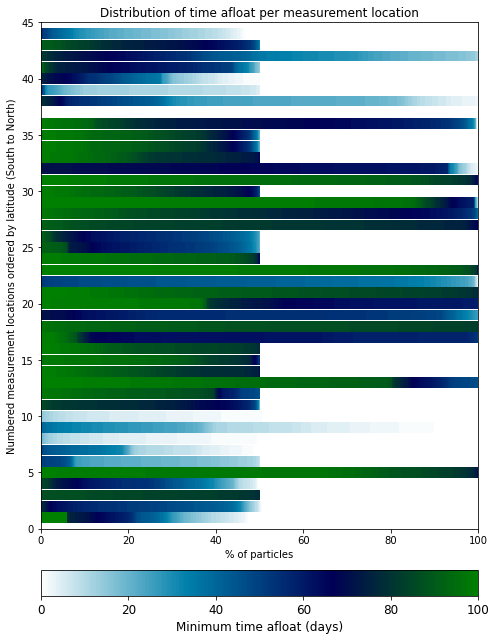

In [4]:
# Figure distribution of how long particles are afloat before arriving at the measurement location

labels = np.arange(0,len(lat_obs))
width = 0.95
increments = np.arange(0,len(days_afloat)-2)
increments = np.flipud(increments)
cmap = plt.cm.get_cmap('ocean_r')
colors = np.linspace(0,1,num=distribution_afloat.shape[1],endpoint=True)

fig = plt.figure(figsize=(7,9))
gs = fig.add_gridspec(2, 1, width_ratios=[1], height_ratios = [1,0.05])

# plot model results
ax1 = fig.add_subplot(gs[0,0])

ax1.barh(labels+1,distribution_afloat[np.argsort(lat_obs),-1],width,color=cmap(colors[-1]),align='center')
bottom_layer = distribution_afloat[np.argsort(lat_obs),-1]
for dt in increments:
    ax1.barh(labels+1,distribution_afloat[np.argsort(lat_obs),dt],width,left=bottom_layer,color=cmap(colors[dt]),align='center')
    bottom_layer = bottom_layer + distribution_afloat[np.argsort(lat_obs),dt]

ax1.set_ylabel('Numbered measurement locations ordered by latitude (South to North)')
ax1.set_xlabel('% of particles')
ax1.set_title('Distribution of time afloat per measurement location')
ax1.set_xlim([0,100])
ax1.set_ylim([0,45])

# add colorbar
im = ax1.scatter(-10*(colors+10),-10*(colors+10),s=20,c=colors,cmap='ocean_r',vmin=0,vmax=100)
ax2 = fig.add_subplot(gs[1,0])
cbr = plt.colorbar(im, cax=ax2, orientation='horizontal')
cbr.set_label('Minimum time afloat (days)', fontsize=12)
cbr.ax.tick_params(labelsize=12)

# Save figure
plt.tight_layout()
plt.savefig('figures/Sensitivity_daysafloat_7d.png',dpi=300,facecolor='#ffffff')


In [ ]:
# Figure observations & the distribution of how long particles are afloat before arriving at the measurement location

labels = np.arange(0,len(lat_obs))
width = 0.95
increments = np.arange(0,len(days_afloat)-2)
increments = np.flipud(increments)
cmap = plt.cm.get_cmap('ocean_r')
colors = np.linspace(0,1,num=distribution_afloat.shape[1],endpoint=True)

fig = plt.figure(figsize=(12,9))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios = [1,0.05])

# plot model results
ax1 = fig.add_subplot(gs[0,1])

ax1.barh(labels+1,distribution_afloat[np.argsort(lat_obs),-1],width,color=cmap(colors[-1]),align='center')
bottom_layer = distribution_afloat[np.argsort(lat_obs),-1]
for dt in increments:
    ax1.barh(labels+1,distribution_afloat[np.argsort(lat_obs),dt],width,left=bottom_layer,color=cmap(colors[dt]),align='center')
    bottom_layer = bottom_layer + distribution_afloat[np.argsort(lat_obs),dt]

ax1.set_ylabel('Numbered measurement locations ordered by latitude (South to North)')
ax1.set_xlabel('% of particles')
ax1.set_title('Fig. 2b Distribution of time afloat per measurement location')
ax1.set_xlim([0,100])
ax1.set_ylim([0,45])

# add colorbar
im = ax1.scatter(-10*(colors+10),-10*(colors+10),s=20,c=colors,cmap='ocean_r',vmin=0,vmax=100)
ax2 = fig.add_subplot(gs[1,1])
cbr = plt.colorbar(im, cax=ax2, orientation='horizontal')
cbr.set_label('Minimum time afloat (days)', fontsize=12)
cbr.ax.tick_params(labelsize=12)

# add colorbar for observations
color_obs=np.zeros((len(labels),4))
cmap2 = plt.cm.get_cmap('tab10')
teller=0
for i in obs.Label:
    if i=='confident':
        color_obs[teller,:]=cmap2(0)
    if i=='low':
        color_obs[teller,:]=cmap2(0.1)
    if i=='excluded':
        color_obs[teller,:]=cmap2(0.3)
    teller += 1

# add observations
ax3 = fig.add_subplot(gs[0,0])
ax3.set_yticklabels([]) 
ax3.set_yticks([]) 
ax4 = ax3.twinx()
ax4.barh(labels+1,-(obs.Estimate[np.argsort(lat_obs)]+0.1),width,align='center',color=color_obs[np.argsort(lat_obs),:])
ax4.set_ylim([0,45])
ax4.set_xlim([-30,0.5])
xlabels = ['30','25','20','15','10','5','0']
ax4.set_xticks(np.arange(-35,0,5))
ax4.set_xticklabels(xlabels)
ax3.set_xlabel('% of items with interactions')
ax4.set_title('Fig. 2a Estimate from observations')

From Figure 2 we can see the distribution of how long particles have been afloat before they arrive at the measurement location. For example, at measurement location 5 (Rapa Nui) almost all particles have been afloat for more than 90 days, whereas at measurement location 10 (Perú, Puerto Chancay) many particles stayed in coastal cells. We can now tune the 'minimum time afloat' parameter to find the best fit with the observed distribution (Fig 2a). For this we only included all 'confident' measurements and excluded the measurement on Rapa Nui, as this outlier dominates the correlation we can find.

70


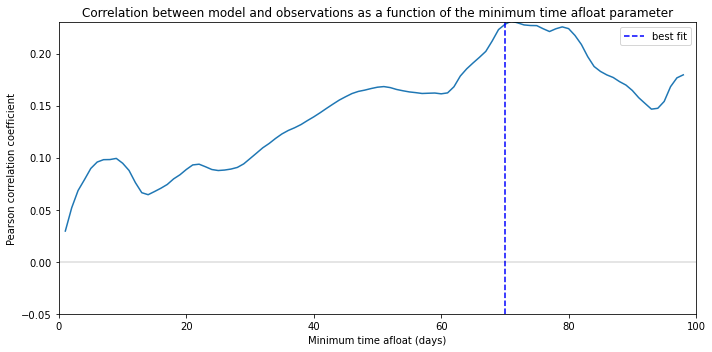

In [5]:
# Figure showing Pearson correlation coefficient as a function of minimum time afloat

obs.iloc[43,6] = 'excluded' #exclude Rapa Nui

best_fit = np.flip(distribution_afloat, 1)
best_fit = np.cumsum(best_fit,axis=1)

corr = []
for b in np.arange(1,len(days_afloat)-2):
    corr.append(pearsonr(best_fit[obs.Label=='confident',b],obs.Estimate[obs.Label=='confident'])[0])

obs.iloc[43,6] = 'confident' #include Rapa Nui again    
    
fig,axs = plt.subplots(1, figsize=(10,5))

# plot correlation as a function of minimum time afloat
axs.plot(days_afloat[1:-2],np.flipud(corr))
axs.set_xlabel('Minimum time afloat (days)')
axs.set_ylabel('Pearson correlation coefficient')
axs.plot([np.argmax(np.flipud(corr)),np.argmax(np.flipud(corr))],[-0.05,0.4],'--b',label='best fit')
axs.plot([0,100],[0,0],c='k',linewidth=0.2)
axs.set_title('Correlation between model and observations as a function of the minimum time afloat parameter')
axs.legend()
axs.set_ylim([-0.05,0.23])
axs.set_xlim([0,100])

print(np.argmax(np.flipud(corr)))

# Save figure
plt.tight_layout()
plt.savefig('figures/tuning_7d.png',dpi=300,facecolor='#ffffff')

In [ ]:
# Correlation plot

obs.iloc[43,6] = 'excluded' #exclude Rapa Nui

best_fit = np.flip(distribution_afloat, 1)
best_fit = np.cumsum(best_fit,axis=1)

corr = []
for b in np.arange(1,len(days_afloat)-2):
    corr.append(pearsonr(best_fit[obs.Label=='confident',b],obs.Estimate[obs.Label=='confident'])[0])

obs.iloc[43,6] = 'confident' #include Rapa Nui again    
    
fig,ax = plt.subplots(2,1, figsize=(12,10))

# plot correlation as a function of minimum time afloat
ax[0].plot(days_afloat[1:-2],np.flipud(corr))
ax[0].set_xlabel('Minimum time afloat (days)')
ax[0].set_ylabel('Pearson correlation coefficient')
ax[0].plot([np.argmax(np.flipud(corr)),np.argmax(np.flipud(corr))],[-0.05,0.4],'--b',label='best fit')
ax[0].plot([0,100],[0,0],c='k',linewidth=0.2)
ax[0].set_title('Fig 3a Correlation between model and observations as a function of the minimum time afloat parameter')
ax[0].legend()
ax[0].set_ylim([-0.05,0.23])
ax[0].set_xlim([0,100])

# plot observations vs. model estimate   
for i,err in enumerate(err_obs):
    if err == 'confident':
        ax[1].scatter(lat_obs[i],est_obs[i],c='blue',zorder=20,alpha=0.5)
    elif err == 'low':
        ax[1].scatter(lat_obs[i],est_obs[i],c='orange',zorder=20,alpha=0.5)
    elif err == 'excluded':
        ax[1].scatter(lat_obs[i],est_obs[i],c='red',zorder=20,alpha=0.5)
ax2 = ax[1].twinx()
ax2.scatter(lat_obs,best_fit[:,np.argmax(corr)],c='k',alpha=0.3)
ax2.plot(lat_obs[np.argsort(lat_obs)],best_fit[np.argsort(lat_obs),np.argmax(corr)],c='k',linewidth=0.5)
ax[1].set_xlabel('Latitude')
ax[1].set_ylabel('Observed estimate (%)')
ax2.set_ylabel('Fraction of particles afloat longer than ' + str(np.argmax(np.flipud(corr))) + ' days (%)')
ax[1].set_ylim([-1,32])
ax2.set_ylim([-1,102])

# get legend
ax[1].scatter(-10,-10,c='blue',alpha=0.5,label='high confidence measurement')
ax[1].scatter(-10,-10,c='orange',alpha=0.5,label='low confidence measurement')
ax[1].scatter(-10,-10,c='red',alpha=0.5,label='excluded measurement')
ax[1].scatter(-10,-10,c='k',alpha=0.5,label='modeled estimate')
ax[1].legend(loc='center left')

ax[1].set_title('Fig 3b Comparison observations to measurements')


In [ ]:
# Calculate correlation and significance of full data set

c_conf, p_conf = pearsonr(best_fit[obs.Label=='confident',np.argmax(corr)],obs.Estimate[obs.Label=='confident'])
c_low, p_low = pearsonr(best_fit[obs.Label!='excluded',np.argmax(corr)],obs.Estimate[obs.Label!='excluded'])

print('The pearson correlation coefficient including only the confident observations (ánd Rapa Nui) is ', round(c_conf,2), ',')
print('with a p_value of ', round(p_conf,3))
print('The pearson correlation coefficient including the high and low confident observations is ', round(c_low,2), ',')
print('with a p_value of ', round(p_low,3))


Note that our aim is not to match the absolute percentage from the observations, but to match the spatial distribution. Therefore, the x-axis do not have the same limits (rephrase).

The maximum Pearson correlation is found for a 'afloat' value of 72 days. This means that we find the best correlation between the spatial distribution of the fraction of particles afloat for longer than 72 days as  predicted by the model and the spatial distribution of plastic items with interactions found on the beaches. The correlation, when including Rapa Nui, is relatively low (0.38), but if we look at the large scale, we do seem to capture some of the spatial variability with this approach (Fig. 3b).

> I'm not sure how to assess the significance of this correlation. As we only have 30 data points, the p-value is not so insightful.

We did try many different ways of defining this 'minimum time afloat' parameter (and as mentioned also used e.g. mean speed of the particles, distance to the measurement location and combinations of these), but the result above provided the most optimum correlation and, from an interpretation point of view, makes most sense.

## Extended analysis

It is possible to extend this analysis further by for example
- Investigating how the distribution changes if we include the effect of wind on the floating debris/particles. This does add another tuning parameter (the windage coefficient), which is more difficult to tune as you have to rerun the particle simulation for every value.
- Extrapolate the calculation of the '% of particles afloat > T days' for all locations along the American coastline.
- Repeat analysis for monthly values (instead of whole year before measurement took place). 
